In [26]:
import pandas as pd
import numpy as np
import nolearn
import matplotlib.pyplot as plt
import seaborn
import sklearn.linear_model as lm
import scipy.stats as sps
import math

from Bio import SeqIO
from collections import Counter
from decimal import Decimal
from lasagne import layers, nonlinearities
from lasagne.updates import nesterov_momentum
from lasagne import layers
from nolearn.lasagne import NeuralNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR

seaborn.set_style('white')
seaborn.set_context('poster')

%matplotlib inline

In [2]:
# Read in the protease inhibitor data
widths = [8]
widths.extend([4]*8)
widths.extend([4]*99)
data = pd.read_csv('hiv-protease-data.csv', index_col='SeqID')
drug_cols = data.columns[0:8]
feat_cols = data.columns[8:]

In [3]:
# Read in the consensus data
consensus = SeqIO.read('hiv-protease-consensus.fasta', 'fasta')

consensus_map = {i+1:letter for i, letter in enumerate(str(consensus.seq))}

In [4]:
# Because there are '-' characters in the dataset, representing consensus sequence at each of the positions, 
# they need to be replaced with the actual consensus letter.

for i, col in enumerate(feat_cols):
    # Replace '-' with the consensus letter.
    data[col] = data[col].replace({'-':consensus_map[i+1]})
    
    # Replace '.' with np.nan
    data[col] = data[col].replace({'.':np.nan})
    
    # Replace 'X' with np.nan
    data[col] = data[col].replace({'X':np.nan})

In [5]:
# Drop any feat_cols that have np.nan inside them. We don't want low quality sequences.
data.dropna(inplace=True, subset=feat_cols)

In [6]:
# Drop any feat_cols that are completely conserved.

# The nonconserved_cols list will serve as a convenient selector for the X- data from the 
# original dataframe.
nonconserved_cols = []
for col in feat_cols:
    if len(pd.unique(data[col])) == 1:
        data.drop(col, axis=1, inplace=True)
        
    else:
        nonconserved_cols.append(col)

In [7]:
drug_cols

Index(['FPV', 'ATV', 'IDV', 'LPV', 'NFV', 'SQV', 'TPV', 'DRV'], dtype='object')

In [11]:
def x_equals_y(y_test):
    """
    A function that returns a range from minimum to maximum of y_test.
    
    Used below in the plotting below.
    """
    floor = math.floor(min(y_test))
    ceil = math.ceil(max(y_test))
    x_eq_y = range(floor, ceil)
    return x_eq_y

TWOPLACES = Decimal(10) ** -2

In [137]:
colnum = 7

drug_df = pd.DataFrame()
drug_df[drug_cols[colnum]] = data[drug_cols[colnum]]
drug_df[nonconserved_cols] = data[nonconserved_cols]
for col in nonconserved_cols:
    drug_df[col] = drug_df[col].apply(lambda x: np.nan if len(x) > 1 else x)
drug_df.dropna(inplace=True)

drug_X = drug_df[nonconserved_cols]
drug_Y = drug_df[drug_cols[colnum]].apply(lambda x:np.log(x))

from isoelectric_point import isoelectric_points
from molecular_weight import molecular_weights

# Standardize pI matrix. 7 is neutral
drug_X_pi = drug_X.replace(isoelectric_points)

# Standardize MW matrix.
drug_X_mw = drug_X.replace(molecular_weights)

# Binarize drug_X matrix.
from sklearn.preprocessing import LabelBinarizer
drug_X_bi = pd.DataFrame()
binarizers = dict()

for col in drug_X.columns:
    lb = LabelBinarizer()
    binarized_cols = lb.fit_transform(drug_X[col])
    # print(binarized_cols)
    if len(lb.classes_) == 2:
        # print(binarized_cols)
        drug_X_bi[col] = pd.Series(binarized_cols[:,0])
    else:
        for i, c in enumerate(lb.classes_):
            # print(col + c)
            # print(binarized_cols[:,i])

            drug_X_bi[col + '_' + c] = binarized_cols[:,i]
        
drug_X_bi

,P2_Q,P3_F,P3_I,P3_L,P3_M,P4,P5_L,P6,P7,P8_R,...,P92_Q,P92_R,P93,P94_G,P95_C,P95_F,P95_G,P96_T,P97_L,P98_N
0,0,0,1,0,0,1,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0
1,0,0,1,0,0,1,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0
2,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,0,1,0,0,1,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0
4,0,0,1,0,0,1,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0
5,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
6,0,0,1,0,0,1,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0
7,0,0,1,0,0,1,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0
8,0,0,1,0,0,1,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0
9,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0


0.791936699165 0.52059326121


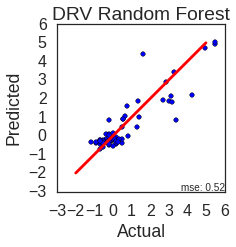

In [138]:
# Here, let's try the Random Forest Regressor. This will be the baseline.
x_train, x_test, y_train, y_test = train_test_split(drug_X_bi, drug_Y)

rfr = RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True)

rfr.fit(x_train, y_train)
rfr_preds = rfr.predict(x_test)
print(rfr.score(x_test, y_test), mean_squared_error(rfr_preds, y_test))
rfr_mse = mean_squared_error(rfr_preds, y_test)
# print(rfr.oob_score_)
sps.pearsonr(rfr_preds, y_test)

plt.figure(figsize=(3,3))
plt.scatter(y_test, rfr_preds,)
plt.title('{0} Random Forest'.format(drug_cols[colnum]))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.gca().set_aspect('equal', 'datalim')
plt.annotate(s='mse: {0}'.format(str(Decimal(rfr_mse).quantize(TWOPLACES))), xy=(1,0), xycoords='axes fraction', ha='right', va='bottom')
plt.plot(x_equals_y(y_test), x_equals_y(y_test), color='red')
plt.show()

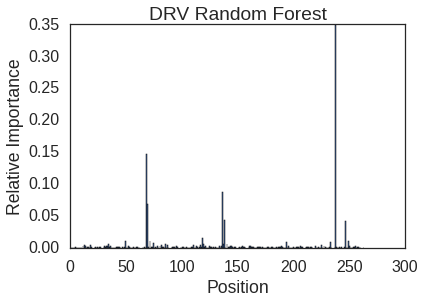

In [139]:
plt.bar(range(len(rfr.feature_importances_)), rfr.feature_importances_)
plt.xlabel('Position')
plt.ylabel('Relative Importance')
plt.title('{0} Random Forest'.format(drug_cols[colnum]))

In [140]:
# Get back the importance of each feature.
feat_impt = [(p, i) for p, i in zip(drug_X_bi.columns, rfr.feature_importances_)]
sorted(feat_impt, key=lambda x:x[1], reverse=True)

[('P84', 0.3486232312107721),
 ('P32', 0.14617645597919385),
 ('P54_I', 0.087226520004921052),
 ('P33_F', 0.067692814513747174),
 ('P54_M', 0.043842783147955595),
 ('P89_L', 0.041969939343740541),
 ('P46_M', 0.014682237369981655),
 ('P89_V', 0.010931151205167786),
 ('P33_L', 0.0097367585694599027),
 ('P20_K', 0.0097112003371407005),
 ('P82_V', 0.0090945036026502581),
 ('P71_V', 0.0084959009598909244),
 ('P34_E', 0.0066377674194087796),
 ('P54_V', 0.006040944919568682),
 ('P54_L', 0.0056259915468341087),
 ('P36_I', 0.0055176984247985615),
 ('P47_A', 0.005451356750349981),
 ('P16_A', 0.0050388858450114227),
 ('P36_M', 0.0045715354993379866),
 ('P11_V', 0.0041603867657123324),
 ('P10_I', 0.0038644735594326515),
 ('P46_I', 0.0037328697150484161),
 ('P43_K', 0.0035472401832223337),
 ('P82_A', 0.003520307251511394),
 ('P35_E', 0.0034256705282589041),
 ('P34_V', 0.0032745991611002005),
 ('P47_V', 0.0032199663343759153),
 ('P54_A', 0.0032099727858412616),
 ('P62', 0.0030718383615506552),
 ('P7

In [141]:
# # Here, let's try a parameter grid search, to figure out what would be the best 
# from sklearn.grid_search import GridSearchCV
# import numpy as np

# param_grid = [{'n_estimators':[100, 500, 1000],
#                #'max_features':['auto', 'sqrt', 'log2'],
#                #'min_samples_leaf':np.arange(1,20,1),
#               }]

# x_train, x_test, y_train, y_test = train_test_split(fpv_X_bi, fpv_Y)


# rfr_gs = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, n_jobs=-1)
# rfr_gs.fit(x_train, y_train)
# print(rfr_gs.best_estimator_)
# print(rfr_gs.best_params_)

0.757200097449 0.607507391182
(0.8729341410116066, 1.2699433075879156e-21)


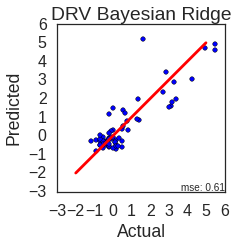

In [142]:
# Try Bayesian Ridge Regression
# x_train, x_test, y_train, y_test = train_test_split(drug_X_bi, drug_Y)

brr = lm.BayesianRidge()
brr.fit(x_train, y_train)
brr_preds = brr.predict(x_test)
print(brr.score(x_test, y_test), mean_squared_error(brr_preds, y_test))
print(sps.pearsonr(brr_preds, y_test))
brr_mse = mean_squared_error(brr_preds, y_test)

plt.figure(figsize=(3,3))
plt.scatter(y_test, brr_preds)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('{0} Bayesian Ridge'.format(drug_cols[colnum]))
plt.gca().set_aspect('equal', 'datalim')
plt.annotate(s='mse: {0}'.format(str(Decimal(brr_mse).quantize(TWOPLACES))), xy=(1,0), xycoords='axes fraction', ha='right', va='bottom')
plt.plot(x_equals_y(y_test), x_equals_y(y_test), color='red')
plt.show()

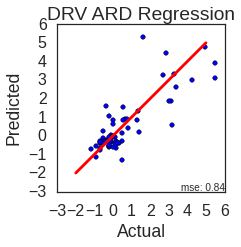

In [143]:
# Try ARD regression
ardr = lm.ARDRegression()
ardr.fit(x_train, y_train)
ardr_preds = ardr.predict(x_test)
ardr_mse = mean_squared_error(ardr_preds, y_test)

plt.figure(figsize=(3,3))
plt.scatter(y_test, ardr_preds)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('{0} ARD Regression'.format(drug_cols[colnum]))
plt.gca().set_aspect('equal', 'datalim')
plt.annotate(s='mse: {0}'.format(str(Decimal(ardr_mse).quantize(TWOPLACES))), xy=(1,0), xycoords='axes fraction', ha='right', va='bottom')
plt.plot(x_equals_y(y_test), x_equals_y(y_test), color='red')
plt.show()

0.726930670611 0.683244244192
(0.85651971787957026, 4.7620640257461273e-20)


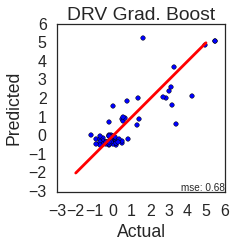

In [144]:
# Try Gradient Boost
# x_train, x_test, y_train, y_test = train_test_split(drug_X_bi, drug_Y)

gbr = GradientBoostingRegressor()
gbr.fit(x_train, y_train)
gbr_preds = gbr.predict(x_test)
print(gbr.score(x_test, y_test), mean_squared_error(gbr_preds, y_test))
print(sps.pearsonr(gbr_preds, y_test))
gbr_mse = mean_squared_error(gbr_preds, y_test)

plt.figure(figsize=(3,3))
plt.scatter(y_test, gbr_preds)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('{0} Grad. Boost'.format(drug_cols[colnum]))
plt.gca().set_aspect('equal', 'datalim')
plt.annotate(s='mse: {0}'.format(str(Decimal(gbr_mse).quantize(TWOPLACES))), xy=(1,0), xycoords='axes fraction', ha='right', va='bottom')
plt.plot(x_equals_y(y_test), x_equals_y(y_test), color='red')
plt.show()

<Container object of 263 artists>

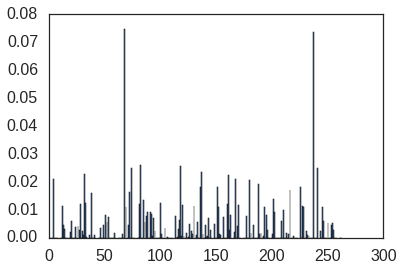

In [145]:
plt.bar(range(len(gbr.feature_importances_)), gbr.feature_importances_)

0.775285332858 0.562256490884
(0.88136748335964898, 1.6136211173342447e-22)


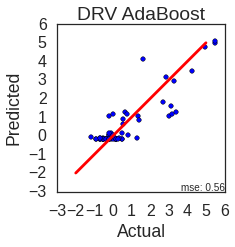

In [146]:
# Try AdaBoost
# x_train, x_test, y_train, y_test = train_test_split(drug_X_bi, drug_Y)

abr = AdaBoostRegressor()
abr.fit(x_train, y_train)
abr_preds = abr.predict(x_test)
print(abr.score(x_test, y_test), mean_squared_error(abr_preds, y_test))
print(sps.pearsonr(abr_preds, y_test))
abr_mse = mean_squared_error(abr_preds, y_test)

plt.figure(figsize=(3,3))
plt.scatter(y_test, abr_preds, )
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('{0} AdaBoost'.format(drug_cols[colnum]))
plt.gca().set_aspect('equal', 'datalim')
plt.annotate(s='mse: {0}'.format(str(Decimal(abr_mse).quantize(TWOPLACES))), xy=(1,0), xycoords='axes fraction', ha='right', va='bottom')
plt.plot(x_equals_y(y_test), x_equals_y(y_test), color='red')
plt.show()

<Container object of 263 artists>

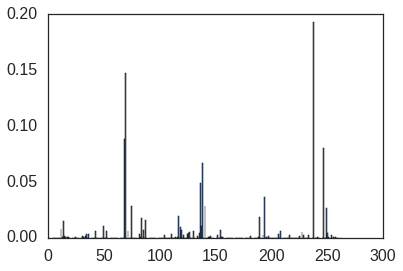

In [147]:
plt.bar(range(len(abr.feature_importances_)), abr.feature_importances_)

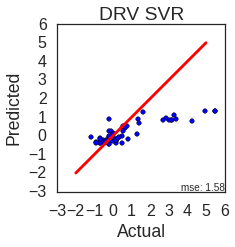

In [148]:
# Try support vector regression
svr = SVR()
svr.fit(x_train, y_train)
svr_preds = svr.predict(x_test)

svr_mse = mean_squared_error(svr_preds, y_test)

plt.figure(figsize=(3,3))
plt.scatter(y_test, svr_preds, )
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('{0} SVR'.format(drug_cols[colnum]))
plt.gca().set_aspect('equal', 'datalim')
plt.annotate(s='mse: {0}'.format(str(Decimal(svr_mse).quantize(TWOPLACES))), xy=(1,0), xycoords='axes fraction', ha='right', va='bottom')
plt.plot(x_equals_y(y_test), x_equals_y(y_test), color='red')
plt.show()

In [149]:
# Neural Network 1 Specification: Feed Forward ANN with 1 hidden layer.
# x_train, x_test, y_train, y_test = train_test_split(drug_X_bi, drug_Y)

x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden1', layers.DenseLayer),
        ('dropout1', layers.DropoutLayer),
        #('hidden2', layers.DenseLayer),
        #('dropout2', layers.DropoutLayer),
        ('nonlinear', layers.NonlinearityLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, x_train.shape[1]),  # 
    hidden1_num_units=math.ceil(x_train.shape[1] / 2),  # number of units in hidden layer
    hidden1_nonlinearity=nonlinearities.tanh,
    dropout1_p = 0.5,
    #hidden2_num_units=math.ceil(x_train.shape[1] / 2),
    #dropout2_p = 0.5,
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=1,  # 30 target values
    
    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.95,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=500,  # we want to train this many epochs
    verbose=1,
    )
net1.fit(x_train.values, y_train.values)

# Neural Network with 34981 learnable parameters

## Layer information

  #  name         size
---  ---------  ------
  0  input         263
  1  hidden1       132
  2  dropout1      132
  3  nonlinear     132
  4  output          1

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       2.33912       2.48055      0.94299  0.00s
      2       1.97008       2.13619      0.92224  0.00s
      3       1.52147       1.83439      0.82941  0.00s
      4       1.38130       1.56885      0.88045  0.00s
      5       1.09238       1.36891      0.79799  0.00s
      6       0.92435       1.26093      0.73307  0.00s
      7       0.86187       1.09142      0.78968  0.00s
      8       0.64996       1.12678      0.57683  0.00s
      9       0.97113       0.91483      1.06154  0.00s
     10       0.67980       0.89101      0.76296  0.00s
     11       0.72673       0.83220      0.87327  0.00s
     12       0.55892       0.77348     

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f8749324a90>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f8749324668>,
     custom_score=None, dropout1_p=0.5,
     hidden1_nonlinearity=<function tanh at 0x7f86fb0e8f28>,
     hidden1_num_units=132, input_shape=(None, 263),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('nonlinear', <class 'lasagne.layers.dense.NonlinearityLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=500, more_params={},
     objective=<function objective at 0x7f86fa37ac80>,
     objective_loss_function=<function squared_error at 0x7f86fac4f840>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x7f869d766b70>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.

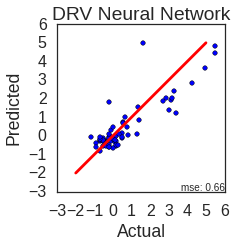

In [150]:
nn1_preds = net1.predict(x_test)
nn1_mse = float(mean_squared_error(nn1_preds, y_test))

plt.figure(figsize=(3,3))
plt.scatter(y_test, nn1_preds)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('{0} Neural Network'.format(drug_cols[colnum]))
plt.gca().set_aspect('equal', 'datalim')
plt.annotate(s='mse: {0}'.format(str(Decimal(nn1_mse).quantize(TWOPLACES))), xy=(1,0), xycoords='axes fraction', ha='right', va='bottom')
plt.plot(x_equals_y(y_test), x_equals_y(y_test), color='red')
plt.show()

In [151]:
sps.pearsonr(nn1_preds, y_test.reshape(y_test.shape[0],1))

(array([ 0.86426854], dtype=float32), array([  9.12747923e-21], dtype=float32))